# PROJETO FINAL 
## Categorização de Grupos Públicos do WhatsApp: Uma Abordagem Automática para Classificação

- Disciplina: Natural Language Processing
- Daniel Pimentel Kansaon


## Objetivos

Sabemos que o WhatsApp é uma plataforma de mensagem privada, mas que tem uma característica de rede social pela da possibilidade da criação de grupos públicos.

Essas plataformas têm chamado muita atenção para muitos estudos sobre desinformação e discurso de ódio. No entanto, pouco esforço tem sido feito na direção de entender quais os conteúdos ali compartilhados.

Nessa direção, esse trabalho visa entender os tipos de assuntos de grupos públicos do WhatsApp. Para isso, o foco será em grupos públicos que são compartilhados e indexados em sites na Web. Neste trabalho, estamos considerando dois web sites com número de grupos.

- https://gruposdezap.com/
- https://gruposwhats.app/

Para o trabalho vamos utilizar duas redes neuronais (LSTM e CNN).

- Objetivo: Dado a descrição e título do grupo, categorizar o assunto do grupo em 20 categorias.

## Organização do Trabalho

O trabalho está organizado da seguinte maneira:
- 1. Definição dos imports e funções que serão utilizadas

- 2. Base de Dados
  - 2.1. Pré-Processamento
  - 2.2. Volume de Mensagens
  - 2.3. Detalhamento das Classes
  - 2.4. Distribuição dos Dados

- 3. Preparação dos Dados
  - 3.1. Tokenizar as Entradas
  - 3.2. Tokenizar as Saídas
  - 3.3. Carregar os Embeddings

- 4. Modelos de Classificação
  - 4.1. Random Forest (RF)
  - 4.2. Long Short Term Memory (LSTM)
  - 4.3. Convolutional Neural Network (CNN 1D)

- 5. Resultados: Dataset 1
  - 5.1. Treinamento: Random Forest (RF)
  - 5.2. Treinamento: Long Short Term Memory (LSTM)
  - 5.3. Treinamento: Convolutional Neural Network (CNN 1D)
  - 5.4. Análise da Matriz de Confusão
  - 5.5. Principais Resultados

- 6. Resultados: Dataset 2
  - 6.1. Treinamento: Random Forest (RF)
  - 6.2. Treinamento: Long Short Term Memory (LSTM)
  - 6.3. Treinamento: Convolutional Neural Network (CNN 1D)
  - 6.4. Análise da Matriz de Confusão
  - 6.5. Principais Resultados

- 7. Avaliação dos Modelos em Bases Diferentes
  - 7.1. Avaliando Modelo Treinado no Dataset 1 para Predizer o Dataset 2
  - 7.2. Avaliando Modelo Treinado no Dataset 2 para Predizer o Dataset 1

- 8. Conclusão

# Executar apenas se for executar pelo google collab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/skip_s100.zip -d ./sample_data/

Archive:  /content/drive/MyDrive/ColabNotebooks/skip_s100.zip
  inflating: ./sample_data/skip_s100.txt  


In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# BIBLIOTECAS

In [ ]:
import json
import gzip
import pandas as pd
import re
import string
import os
from tqdm import tqdm
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize

import plotly.express as px

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as util

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as util
from keras.models import Sequential
from keras.layers import Embedding, InputLayer
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Flatten

from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import MaxPooling1D

from keras.layers import Input
from sklearn.utils import class_weight
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pip2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plot
#import seaborn as sns; sns.set_theme()
import plotly.graph_objects as go

from wordcloud import WordCloud 

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

# CONSTANTES

In [ ]:
#FILE_PATH_ZAP = './scripts/final_data/db_grupos_de_zap.json.gz'
#FILE_PATH_WHATS = './scripts/final_data/db_grupos_whats.json.gz'
#FILE_PATH_CATEG = './scripts/final_data/categories.csv'

FILE_PATH_ZAP = './sample_data/db_grupos_de_zap.json.gz' # https://gruposdezap.com/
FILE_PATH_WHATS = './sample_data/db_grupos_whats.json.gz' # https://gruposwhats.app/
FILE_PATH_CATEG = './sample_data/categories.csv'

EMBEDDING_SIZE = 100
EMBEDDING_PATH = './sample_data/'
K_FOLD = 5
N_CLASSES = 20

STOP_WORDS = set(stopwords.words('portuguese'))

# 1 - MÉTODOS UTILIZADOS

In [ ]:
def read_data(path):
    with gzip.open(path, 'r') as fin:      
        json_bytes = fin.read()  

        json_str = json_bytes.decode('utf-8')            
        data = json.loads(json_str)
    
    return data

## 1.1 - Leitura dos Dados

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
def process_text(text):
    text = remove_emoji(text) #REMOVE EMOJIS
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS]) #REMOVE STOPWORDS
    text = text.translate(str.maketrans('', '', string.punctuation)) #REMOVE PONTUAÇÃO
    text = ' '.join([word for word in text.split() if not word.isdigit()]) #REMOVE DIGITOS
    
    return text.lower()

In [ ]:
def get_df_data(data):
    desc = [data[i]['title'] + ' ' + data[i]['description'] for i in range(0, len(data))]
    cat = [d['category'] for d in data]
    return pd.DataFrame({'description': desc, 'category': cat})

#https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb#scrollTo=AXhAERVeXhmZ

## 1.2 - Função para Matriz de Confusão

In [ ]:
def plot_confusion_matrix(model, x_train, y_train, matrix=[]):    
    y_pred = np.argmax(x_train, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    if len(matrix) > 0:
      cm = matrix
    else:
      cm = confusion_matrix(y_true, y_pred, normalize='true')
    #print(classification_report(y_true, y_pred))
    
    #classes = list(range(1, N_CLASSES))
    fig, ax = plt.subplots(figsize=(14, 14))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=ALL_CATEGORIES, yticklabels=ALL_CATEGORIES,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,str(round(cm[i, j], 2)).strip(), ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

## 1.3 - Função para plotar uma CDF

In [ ]:
def plot_cdf_n_curves(list_curve, label_curve, x_label, chart_path, isLog=True):
    n = len(list_curve)
    ecdf_list = list()
    
    for k in range(n):
        list_curve[k].sort()
        cdf = ECDF(list_curve[k])
        ecdf_list.append(cdf)
    
    fig, ax = plt.subplots()
    plt.grid()
    for k in range(n):
        plt.plot(ecdf_list[k].x, ecdf_list[k].y, label=label_curve[k], linewidth=2)
   
    plt.legend(loc='lower right')
    if isLog:
        chart_path = chart_path+'_log'
        ax.set_xscale('log')
        
    ax.set_xlabel(x_label)
    ax.set_ylabel('CDF')
    plt.tight_layout()
    plot.show()

In [ ]:
def plot_training_performance(acc, val_acc, title):
    plt.figure(figsize=(6,4))
    plt.plot(acc)
    plt.plot(val_acc)

    plt.title(title)
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')

    plt.legend(['Treino', 'Teste'], loc="lower right")
    plt.show()

In [ ]:
def plot_word_cloud(texts):
    long_string = ','.join(texts)
    long_string = long_string.replace('bem vindo', '').replace('grupo', '').replace('aqui','')
    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=1000, height=500)
    
    # Generate a word cloud
    wordcloud.generate(long_string)

    # Visualize the word cloud
    #wordcloud.to_file('words.png')
    return wordcloud.to_image()

# 2 - BASE DE DADOS

Aqui as bases de dados são carregadas dos arquivos json.
- A descrição como a concatenação: Título + Descrição. 
- Nem sempre a descrição é bem escria pelos usuários, mas o título normalmente sumariza o conteúdo. Por esse motivo, utilizamos como entrada da rede esses dois valores.

In [ ]:
df_base1 = get_df_data(read_data(FILE_PATH_ZAP)) #https://gruposdezap.com/
df_base2 = get_df_data(read_data(FILE_PATH_WHATS)) #https://gruposwhats.app/

## 2.1 - Pré-Processamento

Nesta etapa removemos:
- Stop Words
- Digitos
- Emojis
- Grupos sem Descrição
- Grupos Duplicados

In [ ]:
#Remove stopwords, números, pontuações e emojis.
df_base1['description'] = df_base1['description'].apply(process_text)
df_base2['description'] = df_base2['description'].apply(process_text)

In [ ]:
#Remove grupos com descrição nula
df_base1.drop(index=df_base1[df_base1['description'] == ''].index, inplace=True)
df_base2.drop(index=df_base2[df_base2['description'] == ''].index, inplace=True)

In [ ]:
#Remove grupos duplicados
df_base1 = df_base1.drop_duplicates()
df_base2 = df_base2.drop_duplicates()

## 2.3 - Volume das Bases de Dados

Temos duas bases de dados:
- Dataset 1: 17.761 grupos
- Dataset 2: 109.312 grupos

Abaixo, vemos as categorias mais frequentes. Games e Jogos; e Ganhar Dinehiro são as mais populares

In [ ]:
print("Dataset 1- Total: ", len(df_base1))
print("Dataset 2- Total: ", len(df_base2))
print("Total Categorias: ", len(Counter(df_base1['category'])))

Dataset 1- Total:  17761
Dataset 2- Total:  109312
Total Categorias:  20


In [ ]:
qtd_cat_base1 = Counter(df_base1['category'])
qtd_cat_base2 = Counter(df_base2['category'])

In [ ]:
df1 = pd.DataFrame({"Dados": ['Base 1' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base1.keys()), "Quantidade": list(qtd_cat_base1.values())})
df2 = pd.DataFrame({"Dados": ['Base 2' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base2.keys()), "Quantidade": list(qtd_cat_base2.values())})

fig = px.bar(pd.concat([df1, df2]), color='Dados', y='Categoria', x='Quantidade')
fig.show()

## 2.4 - Detalhamento de Cada Classe

Aqui, podemos ver o que significa cada uma das 20 categorias existentes.

In [ ]:
categ_desc = pd.read_csv(FILE_PATH_CATEG, sep=';')
fig = go.Figure(data=[go.Table(header=dict(values=['Categoria', 'Descrição']),
                 cells=dict(values=[list(categ_desc['categoria']), list(categ_desc['descricao'])]))
                     ])
fig.show()

## 2.5 - Distribuição das Categorias

Nesta parte, podemos ver a distribuição (CDF) de cada categoria.

- No Dataset 1: 80% das categorias têm **menos** de 1000 grupos
- No Dataset 2: 80% das categorias têm **mais** de 1000 grupos

Percebemos, que o volume do Dataset 2 é bem maior. Já no Dataset 1, algumas categorias têm poucos dados.

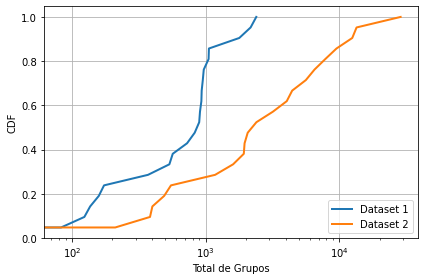

In [ ]:
cdf_db1 = list(qtd_cat_base1.values())
cdf_db2 = list(qtd_cat_base2.values())

plot_cdf_n_curves([cdf_db1, cdf_db2], ['Dataset 1', 'Dataset 2' ], 'Total de Grupos', 'Categoria', isLog=True)

## 2.7 - Núvem de Termos

Temos os temos mais frequêntes em cada Dataset. Isso nos ajuda a entender os termos mais utilizados. Nota-se, que o contexto é um pouco diferente em cada Dataset.

**Dataset 1**

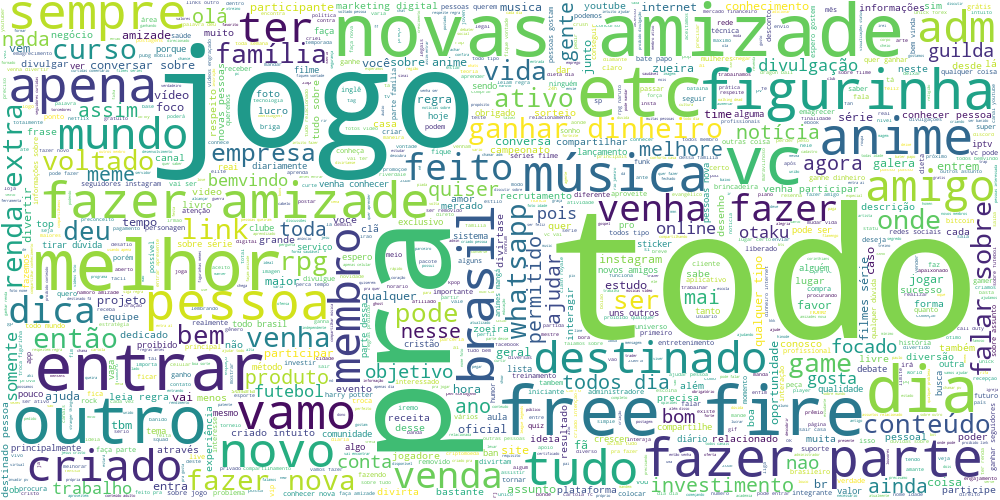

In [ ]:
plot_word_cloud(df_base1['description'])

**Dataset 2**

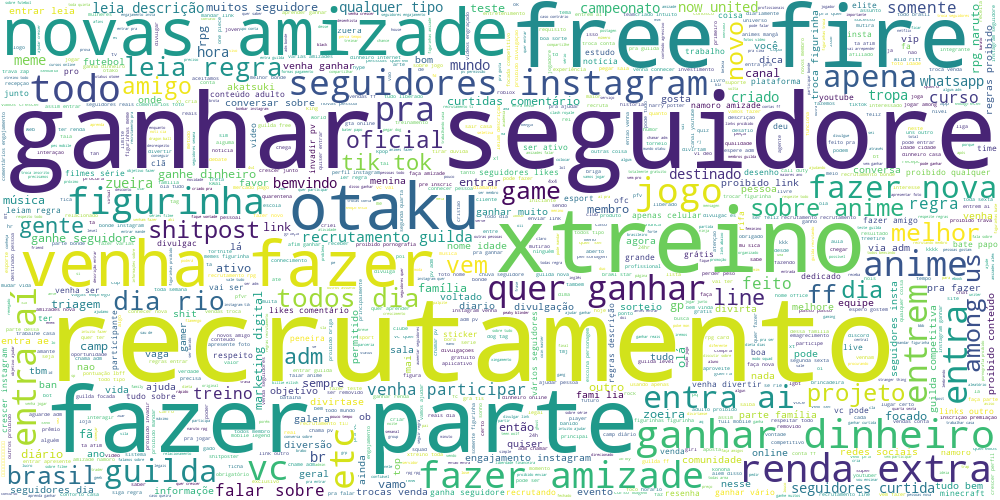

In [ ]:
plot_word_cloud(df_base2['description'])

# 3 - PREPARAÇÃO DOS DADOS

## 3.1 - Tokenizar as Sentences (Título do Grupo + Descrição)

Transforma as sentenças em tokens, ou seja, cada palavra passa a ser representada por um número. Isso será a entrada do nosso modelo.

Ao todo, temos um vocabulário de 118.880 palavras (as palavras são representadas por um número de 0 ao tamanho do vocabulário). Já as sentenças, tem um máximo de 85 palavras.

Exemplo da entrada: [0 0 0 0 0 ... 5 10 15 30]. Cada número representa uma palavra no vocabulário.

In [ ]:
all_descriptions = list(df_base1['description'])
all_descriptions.extend(list(df_base2['description']))

word_tokenizer = Tokenizer(split = ' ')
word_tokenizer.fit_on_texts(all_descriptions)

MAX_WORDS_SENTENCES = 85

SENTENCES_BASE1 = word_tokenizer.texts_to_sequences(df_base1['description']) 
SENTENCES_BASE1 = pad_sequences(SENTENCES_BASE1, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

SENTENCES_BASE2 = word_tokenizer.texts_to_sequences(df_base2['description']) 
SENTENCES_BASE2 = pad_sequences(SENTENCES_BASE2, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

In [ ]:
maior = 0
for c in all_descriptions:
    if maior < len(c.split(' ')):
        maior = len(c.split(' '))
        
print("Maior Sentença: ", maior)

Maior Sentença:  82


In [ ]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
print('Tamanho do Vocabulário: ', VOCABULARY_SIZE)

Tamanho do Vocabulário:  118880


## 3.2 - Tokenizar a Saída (classes)

Nesta parte, transformamos as categorias em números de 0 a 19. Além disso, é necessário usar a função to_categorical() para transformar em um vetor de saída da rede neural.

In [ ]:
ALL_CATEGORIES = list(set(df_base1['category']))
CATEGORY_BASE1 = [ALL_CATEGORIES.index(cat) for cat in df_base1['category']] 
CATEGORY_BASE2 = [ALL_CATEGORIES.index(cat) for cat in df_base2['category']] 

print('ALL: ', ALL_CATEGORIES)
print('Total: ', len(ALL_CATEGORIES))

ALL:  ['tv, desenhos e animes', 'esportes e academia', 'filmes e séries', 'ganhar dinheiro e empregos', 'redes sociais', 'música', 'notícias', 'saúde, emagrecimento e beleza', 'fãs', 'memes engraçados e zoeira', 'religião', 'amor e romance', 'frases e mensagens', 'festas, baladas e eventos', 'figurinhas e stickers', 'política', 'games e jogos', 'carros e motos', 'receitas', 'educação e estudo']
Total:  20


In [ ]:
class_weights_db1 = dict(zip(np.unique(CATEGORY_BASE1), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE1), y=CATEGORY_BASE1)))
class_weights_db2 = dict(zip(np.unique(CATEGORY_BASE2), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE2), y=CATEGORY_BASE2)))

In [ ]:
CATEGORY_BASE1 = util.np_utils.to_categorical(CATEGORY_BASE1, N_CLASSES)
CATEGORY_BASE2 = util.np_utils.to_categorical(CATEGORY_BASE2, N_CLASSES)

print('\nSHAPE: ', CATEGORY_BASE1.shape)
print('SHAPE: ', CATEGORY_BASE2.shape)


SHAPE:  (17761, 20)
SHAPE:  (109312, 20)


## 3.3 - Carregar Embeddings

Como entrada da nossa rede, utilizamos embeddings. Word2Vec: Skip-Gram de 100 Dimensões. 

O arquivo pode ser encontrado: http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s100.zip

O arquivo deve ser extraído e salvo no diretório: ./scripts/embeddings/


In [ ]:
def load_word_embedding(word_index, dimension_embedding):
    dic_embedding = {}
    
    file_embedding = open(os.path.join(EMBEDDING_PATH, "skip_s{}.txt".format(dimension_embedding)), encoding='utf-8')
    
    #Carregando os WordEmbeddings para um dicionario
    for line in tqdm(file_embedding):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefficient = np.asarray(values[1:], dtype='float32')
        dic_embedding[word] = coefficient
            
    file_embedding.close()
    
    #Cria a matrix com em que serão carregados os embeddings
    matrix_embedding = np.zeros((VOCABULARY_SIZE, dimension_embedding))
    
    for word, i in word_index.items():
        if i >= VOCABULARY_SIZE:
            continue
        
        vector_embedding = dic_embedding.get(word)
        
        if vector_embedding is not None:
            matrix_embedding[i] = vector_embedding

    return matrix_embedding

In [ ]:
MATRIX_EMBEDDING = load_word_embedding(word_tokenizer.word_index, EMBEDDING_SIZE)

929607it [00:29, 31733.29it/s]


# 4 - MODELOS DE CLASSIFICAÇÃO

Nesta etapa, vamos construir os modelos de classificação que serão utilizados.
- Random Forest (será o baseline do trabalho)
- LSTM (Bidirecional)
- CNN 1D

In [ ]:
#https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/intervalo-de-confianca-distribuicao-t-de-student/

def calc_conf_interval(v_validation):
    tbl_t_95 = 2.776 #Valor na tabela T-Student (4 graus de liberdade)
    mean = np.mean(v_validation, dtype=np.float64)
    std = np.std(v_validation)
        
    return [mean, (mean - (tbl_t_95 * std)), (mean + (tbl_t_95 * std)), tbl_t_95 * std]

## 4.1 - Modelo Random Forest

In [ ]:
def execute_random_forest(texts_words, y_class, weight):    
    accuracy_train = []
    accuracy_test = []
    macro1_train = []
    macro1_test = []
    weight_f1_test = []
    weight_f1_train = []
    
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)
    
    #Vectoriza os textos, transformando em vetores de números, que representam as frequências
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)   
    
    #Executa a validação cruzada com 5 Folds
    for train_index, test_index in skf.split(texts_words, y_class): 
        model_rf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=150)
        
        #Cria o modelo
        #model_logc = LogisticRegression(solver='newton-cg', class_weight=weight)
     
        #Cria o pipeline para executar o método
        pipe_rf= Pipeline([('vectorizer', vectorizer), ('model_rf', model_rf)])
        
        #Treina e testa salvando os resultados
        pipe_rf.fit(np.array(texts_words)[train_index], np.array(y_class)[train_index])
        accuracy_train.append(pipe_rf.score(np.array(texts_words)[train_index], np.array(y_class)[train_index]))
        accuracy_test.append(pipe_rf.score(np.array(texts_words)[test_index], np.array(y_class)[test_index]))

        pred = pipe_rf.predict(np.array(texts_words)[train_index])
        macro1_train.append(metrics.f1_score(np.array(y_class)[train_index], pred, average='macro'))
        weight_f1_train.append(metrics.f1_score(np.array(y_class)[train_index], pred, average='weighted'))
        
        pred = pipe_rf.predict(np.array(texts_words)[test_index])
        macro1_test.append(metrics.f1_score(np.array(y_class)[test_index], pred, average='macro'))
        weight_f1_test.append(metrics.f1_score(np.array(y_class)[test_index], pred, average='weighted'))
        #break

    return pipe_rf, test_index, accuracy_train, accuracy_test, macro1_train, macro1_test, weight_f1_train, weight_f1_test

## 4.1 - Modelo LSTM

In [ ]:
def load_lstm():
    lstm_model = Sequential()

    lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,        
                             output_dim    = EMBEDDING_SIZE,          
                             input_length  = MAX_WORDS_SENTENCES,     
                             weights       = [MATRIX_EMBEDDING],    
                             trainable     = True                   
    ))

    lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1)))

    lstm_model.add(Flatten())

    lstm_model.add(Dense(N_CLASSES, activation='softmax'))
    
    lstm_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return lstm_model

## 4.3 - Modelo CNN

In [ ]:
def load_cnn1d():
    cnn_model = Sequential()

    cnn_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                             output_dim    = EMBEDDING_SIZE,         
                             input_length  = MAX_WORDS_SENTENCES,    
                             weights       = [MATRIX_EMBEDDING],     
                             trainable     = True                    
    ))

    cnn_model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=4))

    cnn_model.add(Dense(20, activation='relu'))
    cnn_model.add(Dropout(0.20))
    cnn_model.add(Flatten())

    cnn_model.add(Dense(N_CLASSES, activation='sigmoid'))
    
    cnn_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return cnn_model

# 5 - RESULTADOS: DATASET 1

Com os modelos criados, podemos iniciar o treinamento de cada um deles no primeiro Dataset.

## 5.1 - Dataset 1: Treinamento Random Forest

Utilizamos validação cruzada com 5 partições.

Resultados:

- **Acurácia**: 0.685 +- 0.022
- **Macro-F1**: 0.524 +- 0.031
- **Weighted-F1**: 0.671 +- 0.023

In [ ]:
labels = np.argmax(CATEGORY_BASE1, axis=1)
model_rf, t_index, result_train, result_test, macro_train, macro_test, weight_f1_train, weight_f1_test = execute_random_forest(list(df_base1['description']), labels, class_weights_db1)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("ACC Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
    print("Macro-F1 - Treino: {} +- {:.2}".format(calc_conf_interval(macro_train)[0], calc_conf_interval(macro_train)[3]))
    print("Macro-F1 - Teste: {} +- {:.2}".format(calc_conf_interval(macro_test)[0], calc_conf_interval(macro_test)[3]))
    print("Macro-F1 - Treino: {} +- {:.2}".format(calc_conf_interval(weight_f1_train)[0], calc_conf_interval(weight_f1_train)[3]))
    print("Macro-F1 - Teste: {} +- {:.2}".format(calc_conf_interval(weight_f1_test)[0], calc_conf_interval(weight_f1_test)[3]))
else:
    print("ACC - Treino: ", np.mean(result_train))
    print("ACC - Teste: ", np.mean(result_test))
    print("Macro-F1 - Treino: ", np.mean(macro_train))
    print("Macro-F1 - Teste: ",np.mean(macro_test))
    print("Weighted-F1 - Treino: ",np.mean(weight_f1_train))
    print("Weighted-F1 - Teste: ",np.mean(weight_f1_test))


RESULTADOS Logistic Regression

ACC Treino: 0.8576093907220965 +- 0.0028
ACC Teste: 0.6852090163622672 +- 0.022
Macro-F1 - Treino: 0.7753698985974489 +- 0.022
Macro-F1 - Teste: 0.5239296542574998 +- 0.031
Macro-F1 - Treino: 0.8586049405634307 +- 0.0038
Macro-F1 - Teste: 0.6713206273236214 +- 0.023


## 5.2 - Dataset 1: Treinamento LSTM

Abaixo podemos ver todo o histórico de treinamento da LSTM.

- Foram utilizadas 10 épocas com validação cruzada com 5 partições.

Resultado:
- **Acurácia**: 0.7083 +- 0.0098
- **Macro-F1**: 0.64 +- 0.022
- **Weighted-F1**: 0.712 +- 0.0094

In [ ]:
lstm_model_db1 = load_lstm()
lstm_model_db1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           11888000  
                                                                 
 bidirectional (Bidirectiona  (None, 85, 128)          84480     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 10880)             0         
                                                                 
 dense (Dense)               (None, 20)                217620    
                                                                 
Total params: 12,190,100
Trainable params: 12,190,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

i = 1
lstm_db1_accuracy = []
lstm_db1_macro_f1 = []
lstm_db1_wg_f1 = []
db1_lstm_matrix = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))       
    lstm_model_db1 = load_lstm()
    
    db1_lstm_training = lstm_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=10,
        batch_size=1024,
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(lstm_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    lstm_db1_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if len(db1_lstm_matrix) == 0:
      db1_lstm_matrix = confusion_matrix(true, pred, normalize='true')
    else:
      db1_lstm_matrix = db1_lstm_matrix + confusion_matrix(true, pred, normalize='true')

    #if i == 1:
        #break

    i = i + 1

print("\nResultados:")  

if i > 1:  
  db1_lstm_matrix = db1_lstm_matrix/K_FOLD
  print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_accuracy)[0], calc_conf_interval(lstm_db1_accuracy)[3]))
  print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_macro_f1)[0], calc_conf_interval(lstm_db1_macro_f1)[3]))
  print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db1_wg_f1)[0], calc_conf_interval(lstm_db1_wg_f1)[3]))
else:
  print("Acurácia: ", sum(lstm_db1_accuracy)/i)
  print("Macro-F1: ", sum(lstm_db1_macro_f1)/i)
  print("Weighted-F1: ", sum(lstm_db1_wg_f1)/i)

1/5 - Folds

Epoch 1/10
14/14 [==============================] - 15s 763ms/step - loss: 2.6990 - acc: 0.3939 - val_loss: 2.0809 - val_acc: 0.5001
Epoch 2/10
14/14 [==============================] - 10s 739ms/step - loss: 1.7871 - acc: 0.5155 - val_loss: 1.5754 - val_acc: 0.5384
Epoch 3/10
14/14 [==============================] - 10s 730ms/step - loss: 1.2722 - acc: 0.6227 - val_loss: 1.3348 - val_acc: 0.6262
Epoch 4/10
14/14 [==============================] - 10s 755ms/step - loss: 0.9771 - acc: 0.7057 - val_loss: 1.2078 - val_acc: 0.6594
Epoch 5/10
14/14 [==============================] - 10s 741ms/step - loss: 0.7566 - acc: 0.7611 - val_loss: 1.1854 - val_acc: 0.6718
Epoch 6/10
14/14 [==============================] - 10s 729ms/step - loss: 0.5896 - acc: 0.8007 - val_loss: 1.1495 - val_acc: 0.6943
Epoch 7/10
14/14 [==============================] - 11s 809ms/step - loss: 0.4503 - acc: 0.8430 - val_loss: 1.1735 - val_acc: 0.7003
Epoch 8/10
14/14 [==============================] - 10s 

### 5.2.1 - Dataset 1: Resultado LSTM

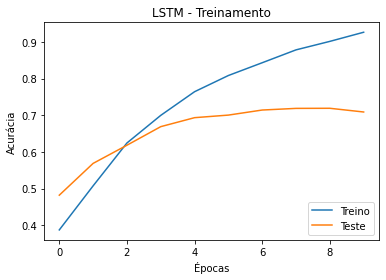

In [ ]:
plot_training_performance(db1_lstm_training.history['acc'], db1_lstm_training.history['val_acc'], "LSTM - Treinamento")

## 5.3 - Dataset 1: Treinamento CNN

Já para o treinamento da CNN:
- Foram 20 épocas com validação cruzada com 5 partições.

Resultado:
- **Acurácia**: 0.723 +- 0.021
- **Macro-F1**: 0.64 +- 0.032
- **Weighted-F1**: 0.725 +- 0.021

In [ ]:
cnn_model_db1 = load_cnn1d()
cnn_model_db1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 85, 100)           11888000  
                                                                 
 conv1d (Conv1D)             (None, 85, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 64)           0         
 )                                                               
                                                                 
 dense_9 (Dense)             (None, 21, 20)            1300      
                                                                 
 dropout (Dropout)           (None, 21, 20)            0         
                                                                 
 flatten_9 (Flatten)         (None, 420)               0         
                                                      

In [ ]:
i = 1

cnn_db1_accuracy = []
cnn_db1_macro_f1 = []
cnn_db1_wg_f1 = []
db1_cnn_matrix = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(i, K_FOLD))   
    cnn_model_db1 = load_cnn1d()
    
    db1_cnn_training = cnn_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=20,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(cnn_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    cnn_db1_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if len(db1_cnn_matrix) == 0:
      db1_cnn_matrix = confusion_matrix(true, pred, normalize='true')
    else:
      db1_cnn_matrix = db1_cnn_matrix + confusion_matrix(true, pred, normalize='true')

    #if i == 1:
        #break
        
    i = i + 1
    

if i > 1:  
  db1_cnn_matrix = db1_cnn_matrix/K_FOLD
  print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_accuracy)[0], calc_conf_interval(cnn_db1_accuracy)[3]))
  print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_macro_f1)[0], calc_conf_interval(cnn_db1_macro_f1)[3]))
  print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db1_wg_f1)[0], calc_conf_interval(cnn_db1_wg_f1)[3]))
else:  
  print("\nResultados:")
  print("Acurácia: ", sum(cnn_db1_accuracy)/i)
  print("Macro-F1: ", sum(cnn_db1_macro_f1)/i)
  print("Weighted-F1: ", sum(cnn_db1_wg_f1)/i)

1/5 - Folds

Epoch 1/20
14/14 [==============================] - 2s 62ms/step - loss: 2.9785 - acc: 0.0688 - val_loss: 2.9198 - val_acc: 0.1157
Epoch 2/20
14/14 [==============================] - 0s 29ms/step - loss: 2.8323 - acc: 0.1774 - val_loss: 2.7251 - val_acc: 0.2606
Epoch 3/20
14/14 [==============================] - 0s 30ms/step - loss: 2.5851 - acc: 0.2850 - val_loss: 2.4323 - val_acc: 0.3344
Epoch 4/20
14/14 [==============================] - 1s 40ms/step - loss: 2.2489 - acc: 0.3532 - val_loss: 2.1096 - val_acc: 0.4036
Epoch 5/20
14/14 [==============================] - 1s 38ms/step - loss: 1.8978 - acc: 0.4265 - val_loss: 1.8211 - val_acc: 0.4844
Epoch 6/20
14/14 [==============================] - 1s 42ms/step - loss: 1.6000 - acc: 0.5108 - val_loss: 1.6212 - val_acc: 0.5334
Epoch 7/20
14/14 [==============================] - 0s 34ms/step - loss: 1.3478 - acc: 0.5788 - val_loss: 1.4253 - val_acc: 0.5843
Epoch 8/20
14/14 [==============================] - 1s 42ms/step - los

### 5.3.1 - Dataset 1: Resultado CNN

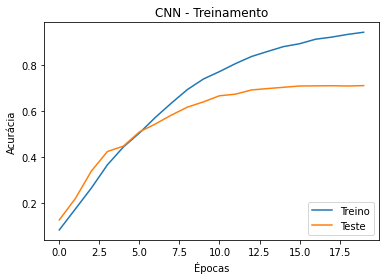

In [ ]:
plot_training_performance(db1_cnn_training.history['acc'], db1_cnn_training.history['val_acc'], "CNN - Treinamento")

## 5.4 - Dataset 1: Matriz de Confusão

Aqui, podemos analisar melhor o resultado detalhado de cada rede. Com a matriz de confusão é possível visualizar quais classes o modelo tem mais dificuldade de prever e quais classes o modelo mais confunde.

### Dataset 1: Matriz de Confusão da LSTM

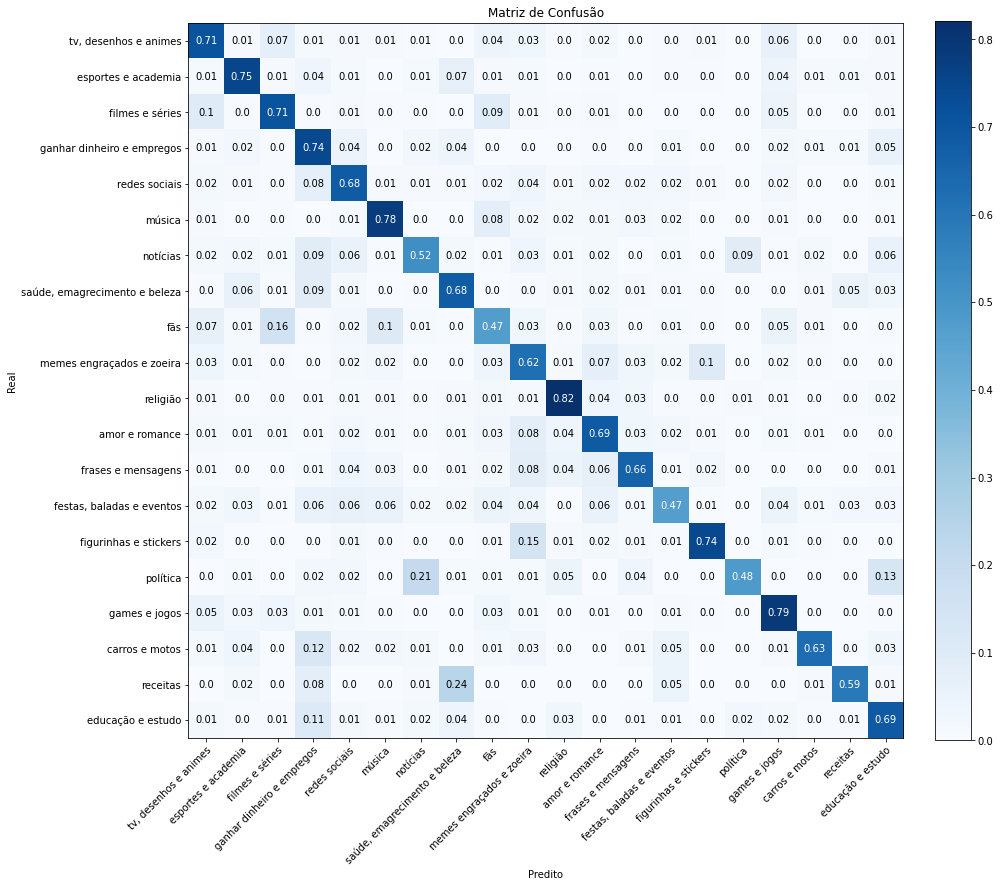

In [ ]:
results_lstm = lstm_model_db1.predict(SENTENCES_BASE1[test_index])
plot_confusion_matrix(lstm_model_db1, results_lstm, CATEGORY_BASE1[test_index], db1_lstm_matrix)

In [ ]:
y_true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
y_pred = np.argmax(results_lstm, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       358
           1       0.68      0.80      0.73       212
           2       0.63      0.71      0.67       185
           3       0.79      0.74      0.77       547
           4       0.66      0.67      0.67       194
           5       0.78      0.80      0.79       190
           6       0.45      0.43      0.44        35
           7       0.71      0.60      0.65       181
           8       0.56      0.44      0.50       180
           9       0.60      0.70      0.64       210
          10       0.86      0.84      0.85       187
          11       0.62      0.69      0.65       146
          12       0.59      0.64      0.61        74
          13       0.28      0.56      0.37        32
          14       0.78      0.64      0.70       107
          15       0.50      0.35      0.41        17
          16       0.87      0.77      0.82       479
          17       0.46    

### Dataset 1: Matriz de Confusão da CNN

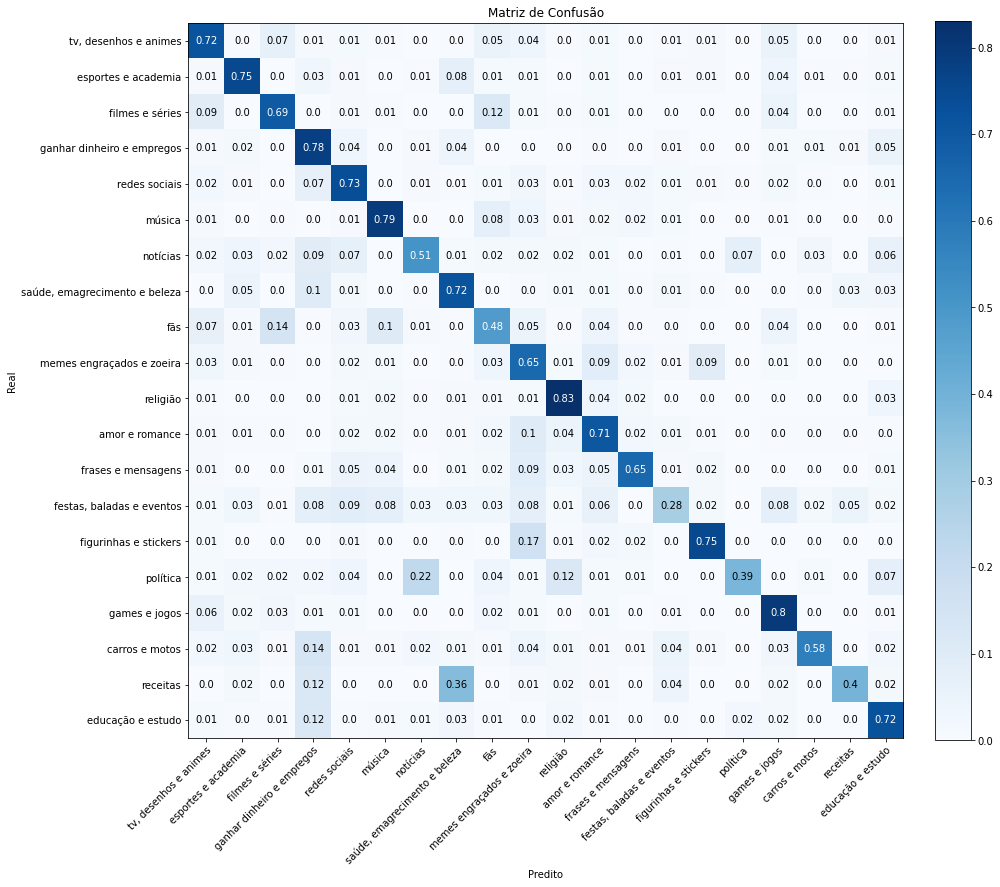

In [ ]:
results_cnn = cnn_model_db1.predict(SENTENCES_BASE1[test_index])
plot_confusion_matrix(cnn_model_db1, results_cnn, CATEGORY_BASE1[test_index], db1_cnn_matrix)

In [ ]:
y_true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
y_pred = np.argmax(results_cnn, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       358
           1       0.79      0.73      0.76       212
           2       0.65      0.70      0.67       185
           3       0.83      0.78      0.80       547
           4       0.72      0.78      0.75       194
           5       0.78      0.82      0.80       190
           6       0.38      0.34      0.36        35
           7       0.69      0.74      0.71       181
           8       0.47      0.43      0.45       180
           9       0.52      0.63      0.57       210
          10       0.80      0.82      0.81       187
          11       0.58      0.65      0.61       146
          12       0.67      0.65      0.66        74
          13       0.36      0.41      0.38        32
          14       0.65      0.71      0.68       107
          15       0.25      0.18      0.21        17
          16       0.85      0.75      0.80       479
          17       0.55    

## 5.5 - Dataset 1: Principais Resultados

De maneira geral, os resutlados apresentados são razoáveis. Com uma acurácia de aproximadamente 70% e Macro-F1 de 65%.

- Apesar de parecer um resultado inferior, o fato de termos 20 classes torna o problema de classificação muito complexo. 

- Mesmo assim, analisando a matriz de confusão, podemos dizer que o modelo consegue distinguir muito bem as principais classes, alcançando em alguns casos mais de 80% de F1-Score.

Um ponto importante é que: No problema, Macro-F1 é muito importante. Uma vez que, em um problema de múltiplas classes, essa métrica nos garante um equilibrio entre precisão e revocação.

Visto isso, mesmo com esse problemas, o modelo consegue uma boa precisão nas principais classes.

As classes com pior desempenho são aquelas que tem muita similaridade com outras. Fãs, Receitas, Festas, Baladas e Eventos. Percebemos que os erros do modelo são totalmente justificáveis para esses casos.

# 6 - RESULTADOS: DATASET 2

As mesmas análises serão feitas agora no segundo Dataset.


## 6.1 - Dataset 2: Treinamento Random Forest


Resultados:
- **Acurácia**: 0.554 +- 0.026
- **Macro-F1**: 0.295 +- 0.015
- **Weighted-F1**: 0.515 +- 0.023



In [ ]:
labels = np.argmax(CATEGORY_BASE2, axis=1)
model_rf, t_index, result_train, result_test, macro_train, macro_test, weight_f1_train, weight_f1_test = execute_random_forest(list(df_base2['description']), labels, class_weights_db2)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("ACC Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
    print("Macro-F1 - Treino: {} +- {:.2}".format(calc_conf_interval(macro_train)[0], calc_conf_interval(macro_train)[3]))
    print("Macro-F1 - Teste: {} +- {:.2}".format(calc_conf_interval(macro_test)[0], calc_conf_interval(macro_test)[3]))
    print("Weighted-F1 - Treino: {} +- {:.2}".format(calc_conf_interval(weight_f1_train)[0], calc_conf_interval(weight_f1_train)[3]))
    print("Weighted-F1 - Teste: {} +- {:.2}".format(calc_conf_interval(weight_f1_test)[0], calc_conf_interval(weight_f1_test)[3]))
else:
    print("ACC - Treino: ", np.mean(result_train))
    print("ACC - Teste: ", np.mean(result_test))
    print("Macro-F1 - Treino: ", np.mean(macro_train))
    print("Macro-F1 - Teste: ",np.mean(macro_test))
    print("Weighted-F1 - Treino: ",np.mean(weight_f1_train))
    print("Weighted-F1 - Teste: ",np.mean(weight_f1_test))


RESULTADOS Logistic Regression

ACC Treino: 0.586696810682454 +- 0.02
ACC Teste: 0.5544862150509849 +- 0.026
Macro-F1 - Treino: 0.3468822820588465 +- 0.014
Macro-F1 - Teste: 0.29461357095816537 +- 0.015
Macro-F1 - Treino: 0.5571541065177236 +- 0.017
Macro-F1 - Teste: 0.5151701076448967 +- 0.023


## 6.2 - Dataset 2: Treinamento LSTM

Resultados:
- **Acurácia**: 0.683 +- 0.04
- **Macro-F1**: 0.611 +- 0.028
- **Weighted-F1**: 0.703 +- 0.027


In [ ]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

In [ ]:
i = 1

lstm_db2_accuracy = []
lstm_db2_macro_f1 = []
lstm_db2_wg_f1 = []
db2_lstm_matrix = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(i, K_FOLD))       
    lstm_model_db2 = load_lstm()
    
    db2_lstm_training = lstm_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=7,
        batch_size=2048, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(lstm_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    lstm_db2_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if len(db2_lstm_matrix) == 0:
      db2_lstm_matrix = confusion_matrix(true, pred, normalize='true')
    else:
      db2_lstm_matrix = db2_lstm_matrix + confusion_matrix(true, pred, normalize='true')

    #if i == 1:
        #break
    
    i = i + 1


print("\nResultados:")  

if i > 1:  
    db2_lstm_matrix = db2_lstm_matrix/K_FOLD
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_accuracy)[0], calc_conf_interval(lstm_db2_accuracy)[3]))
    print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_macro_f1)[0], calc_conf_interval(lstm_db2_macro_f1)[3]))
    print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(lstm_db2_wg_f1)[0], calc_conf_interval(lstm_db2_wg_f1)[3]))
else:     
    print("Acurácia: ", sum(lstm_db2_accuracy)/i)
    print("Macro-F1: ", sum(lstm_db2_macro_f1)/i)
    print("Weighted-F1: ", sum(lstm_db2_wg_f1)/i)

1/5 - Folds

Epoch 1/7
43/43 [==============================] - 35s 718ms/step - loss: 2.3557 - acc: 0.3393 - val_loss: 1.7121 - val_acc: 0.4974
Epoch 2/7
43/43 [==============================] - 31s 713ms/step - loss: 1.3997 - acc: 0.5740 - val_loss: 1.3943 - val_acc: 0.6102
Epoch 3/7
43/43 [==============================] - 30s 701ms/step - loss: 1.0321 - acc: 0.6673 - val_loss: 1.1836 - val_acc: 0.6693
Epoch 4/7
43/43 [==============================] - 31s 724ms/step - loss: 0.8094 - acc: 0.7278 - val_loss: 1.1393 - val_acc: 0.6849
Epoch 5/7
43/43 [==============================] - 30s 697ms/step - loss: 0.6464 - acc: 0.7679 - val_loss: 1.0991 - val_acc: 0.6980
Epoch 6/7
43/43 [==============================] - 31s 722ms/step - loss: 0.5135 - acc: 0.8089 - val_loss: 1.1129 - val_acc: 0.7014
Epoch 7/7
43/43 [==============================] - 31s 729ms/step - loss: 0.4220 - acc: 0.8380 - val_loss: 1.2214 - val_acc: 0.6580
2/5 - Folds

Epoch 1/7
43/43 [==============================] -

### 6.2.1 - Dataset 2: Resultado LSTM

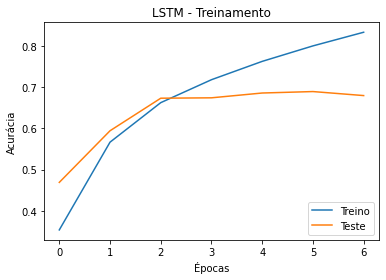

In [ ]:
plot_training_performance(db2_lstm_training.history['acc'], db2_lstm_training.history['val_acc'], "LSTM - Treinamento")

## 6.3 - Dataset 2: Treinamento CNN

Resultados:
- **Acurácia**: 0.701 +- 0.018
- **Macro-F1**: 0.618 +- 0.021
- **Weighted-F1**: 0.712 +- 0.013


In [ ]:
i = 1

cnn_db2_accuracy = []
cnn_db2_macro_f1 = []
cnn_db2_wg_f1 = []
db2_cnn_matrix = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(i, K_FOLD))   
    cnn_model_db2 = load_cnn1d()
    
    db2_cnn_training = cnn_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=15,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(cnn_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    cnn_db2_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if len(db2_cnn_matrix) == 0:
      db2_cnn_matrix = confusion_matrix(true, pred, normalize='true')
    else:
      db2_cnn_matrix = db2_cnn_matrix + confusion_matrix(true, pred, normalize='true')

    #if i == 1:
        #break

    i = i + 1

print("\nResultados:")

if i > 1:  
    db2_cnn_matrix = db2_cnn_matrix/K_FOLD
    print("ACC Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_accuracy)[0], calc_conf_interval(cnn_db2_accuracy)[3]))
    print("Macro-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_macro_f1)[0], calc_conf_interval(cnn_db2_macro_f1)[3]))
    print("Weighted-F1 Teste: {} +- {:.2}".format(calc_conf_interval(cnn_db2_wg_f1)[0], calc_conf_interval(cnn_db2_wg_f1)[3]))
else:     
    print("Acurácia: ", sum(cnn_db2_accuracy)/i)
    print("Macro-F1: ", sum(cnn_db2_macro_f1)/i)
    print("Weighted-F1: ", sum(cnn_db2_wg_f1)/i)

1/5 - Folds

Epoch 1/15
86/86 [==============================] - 3s 26ms/step - loss: 2.7909 - acc: 0.1828 - val_loss: 2.2251 - val_acc: 0.4226
Epoch 2/15
86/86 [==============================] - 2s 23ms/step - loss: 1.8407 - acc: 0.4635 - val_loss: 1.5070 - val_acc: 0.5981
Epoch 3/15
86/86 [==============================] - 2s 23ms/step - loss: 1.2824 - acc: 0.5965 - val_loss: 1.2893 - val_acc: 0.6319
Epoch 4/15
86/86 [==============================] - 2s 23ms/step - loss: 1.0086 - acc: 0.6669 - val_loss: 1.2087 - val_acc: 0.6674
Epoch 5/15
86/86 [==============================] - 2s 23ms/step - loss: 0.8204 - acc: 0.7173 - val_loss: 1.1678 - val_acc: 0.6644
Epoch 6/15
86/86 [==============================] - 2s 24ms/step - loss: 0.6824 - acc: 0.7584 - val_loss: 1.1041 - val_acc: 0.6950
Epoch 7/15
86/86 [==============================] - 2s 24ms/step - loss: 0.5750 - acc: 0.7896 - val_loss: 1.1111 - val_acc: 0.6907
Epoch 8/15
86/86 [==============================] - 2s 24ms/step - los

### 6.3.1 - Dataset 2: Resultado CNN

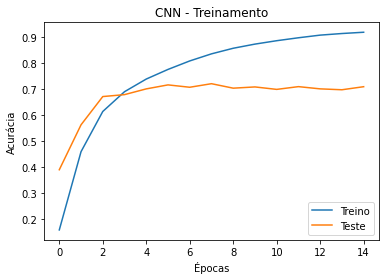

In [ ]:
plot_training_performance(db2_cnn_training.history['acc'], db2_cnn_training.history['val_acc'], "CNN - Treinamento")

## 6.4 - Dataset 2: Matriz de Confusão

### Dataset 2: LSTM

In [ ]:
results = lstm_model_db2.predict(SENTENCES_BASE2[test_index])

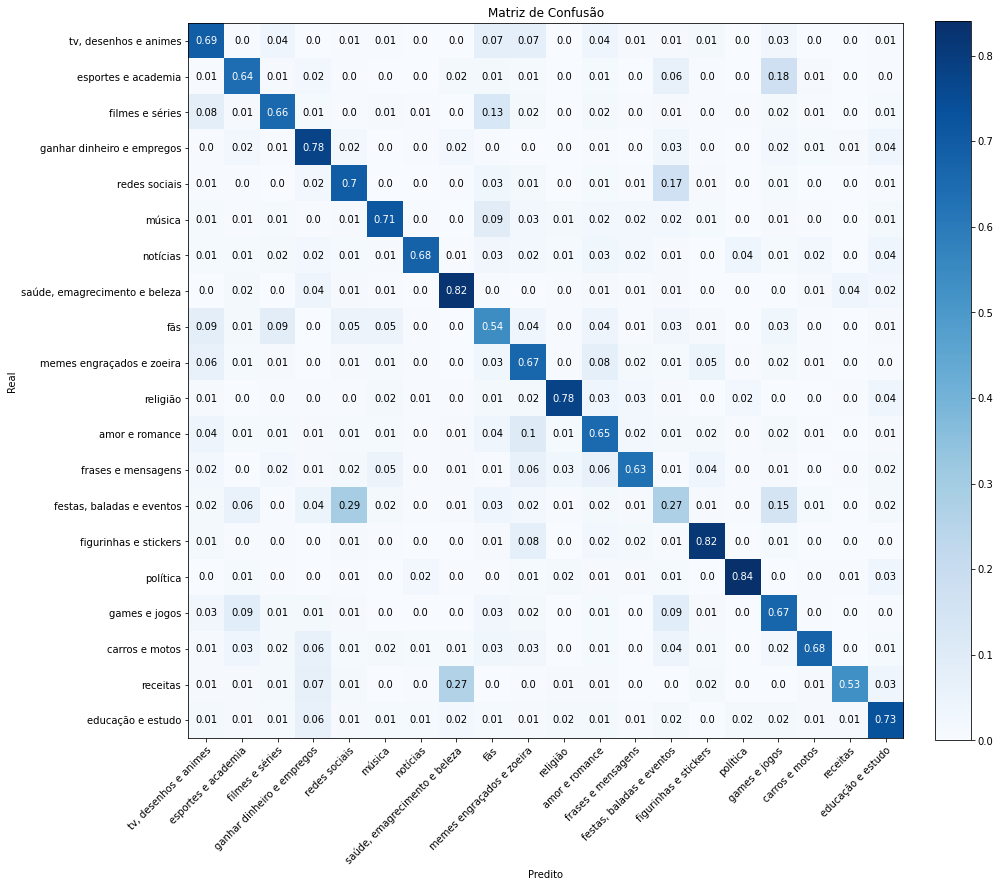

In [ ]:
plot_confusion_matrix(lstm_model_db2, results, CATEGORY_BASE2[test_index], db2_lstm_matrix)

In [ ]:
y_true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
y_pred = np.argmax(results, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      2505
           1       0.40      0.62      0.49       811
           2       0.45      0.65      0.54       386
           3       0.81      0.84      0.83      1809
           4       0.84      0.78      0.81      2696
           5       0.64      0.68      0.66       392
           6       0.58      0.66      0.62        77
           7       0.85      0.82      0.84       637
           8       0.50      0.56      0.53      1308
           9       0.71      0.64      0.68      1908
          10       0.80      0.75      0.77       322
          11       0.45      0.70      0.55       891
          12       0.27      0.65      0.38       110
          13       0.08      0.25      0.12       414
          14       0.71      0.83      0.76      1136
          15       0.59      0.80      0.68        98
          16       0.90      0.62      0.74      5759
          17       0.39    

### Dataset 2: CNN

In [ ]:
results_cnn_db2 = cnn_model_db2.predict(SENTENCES_BASE2[test_index])

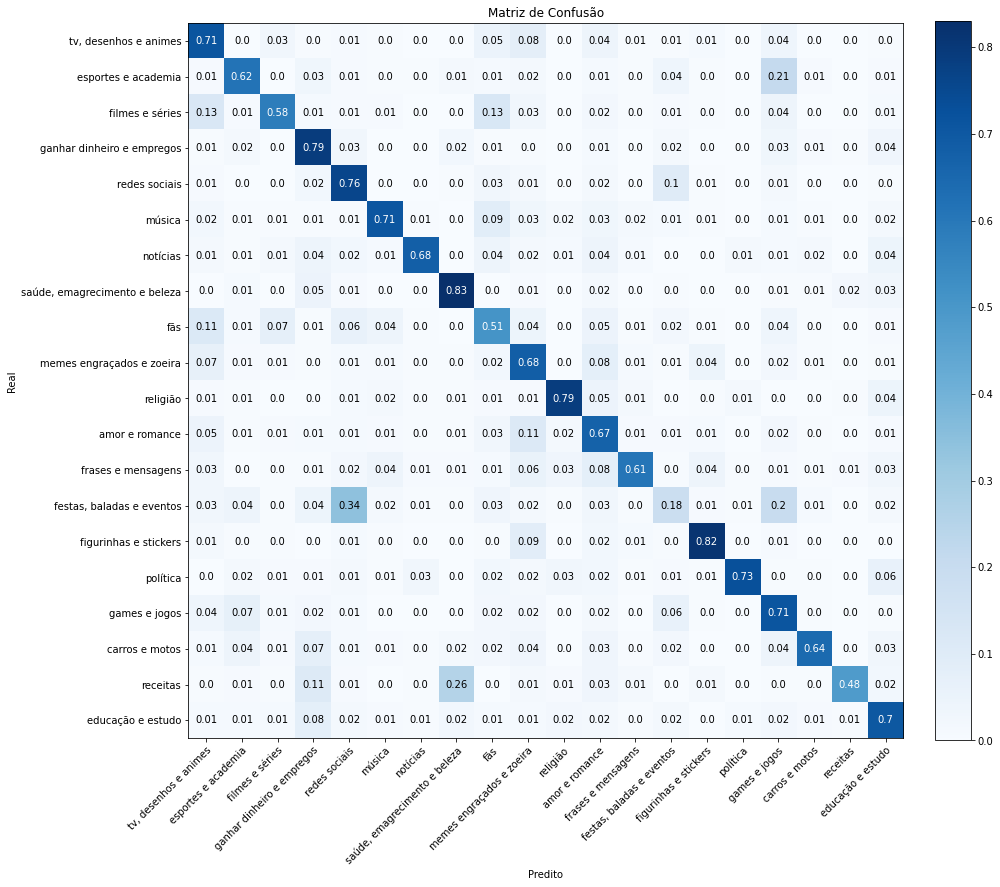

In [ ]:
plot_confusion_matrix(cnn_model_db2, results_cnn_db2, CATEGORY_BASE2[test_index], db2_cnn_matrix)


In [ ]:
y_true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
y_pred = np.argmax(results_cnn_db2, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      2505
           1       0.52      0.61      0.56       811
           2       0.44      0.64      0.52       386
           3       0.79      0.80      0.79      1809
           4       0.83      0.78      0.80      2696
           5       0.63      0.70      0.67       392
           6       0.52      0.65      0.57        77
           7       0.81      0.85      0.83       637
           8       0.57      0.49      0.53      1308
           9       0.68      0.66      0.67      1908
          10       0.80      0.77      0.78       322
          11       0.50      0.69      0.58       891
          12       0.45      0.63      0.52       110
          13       0.09      0.14      0.11       414
          14       0.82      0.85      0.83      1136
          15       0.63      0.74      0.68        98
          16       0.87      0.72      0.79      5759
          17       0.40    

## 6.5 - Dataset 2: Principais Resultados

Aqui, podemos analisar a capacidade dos modelos em acertar cada classe. Abaixo temos algumas análises interessantes.

Classes semelhantes:
- Receitas || Sáude, beleza e emagrecimento
  - Isso occore pois são temas próximos. Existem receitas de alimentos, mas também de dieta, receita para o cabelo e rosto. São temas próximos.

- Festas e Baladas || Rede Social
  - Nesse caso, os termos são bem semelhantes, até porque festas são muito divulgadas em redes sociais.

Além desses casos, percebemos casos em que as classes são ambíguas.
- Fãs: Temos fãs de música, filmes, séries. 
- Figurinhas e Stikers: Memes engraçados

De maneira geral, percebemos o modelo consegue classificar razoavelmente cada uma das classes. No entanto, existem classes mais fáceis e outras mais difíces. Isso faz com que o resultado geral, que é uma média, não seja tão alto. Porém o modelo mostra ser capaz de discriminar as principais classes.

# 7 - AVALIANDO OS MODELOS EM BASES DIFERENTES

Nesta etapa, iremos avaliar os modelos nas bases de dados diferentes. Isso nos ajudará a interpretar os resultados e, principalmente, verificar a semelhança dos contextos e se tivermos overfitting.

## 7.1 - Avaliando: Modelo Treinado no **Dataset 1** para Predizer o **Dataset 2**

Resultado:
- **Acurácia**: 0.54
- **Macro-F1**: 0.41
- **Weighted**: 0.55


Podemos perceber que o resultado não é tão bom ao avaliar no Dataset 2. 

- Uma das razões é o fato do primeiro dataset ter menos exemplos e possivelmente o modelo não ter aprendido todos os padrões da classe.

- Um outro fato, é que algumas classes podem ter definições completamente diferentes. 

- Vemos que as classes: Figurinhas, Política e Festas e Baladas, o modelo vai muito mal.

- Isso nos leva a crer que o modelo não aprendeu corretamente esses padrões.

### 7.1.1 - LSTM

In [ ]:
results = lstm_model_db1.predict(SENTENCES_BASE2)
y_true = np.argmax(CATEGORY_BASE2, axis=1)
y_pred = np.argmax(results, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54     12526
           1       0.29      0.60      0.39      4052
           2       0.25      0.62      0.35      1932
           3       0.80      0.63      0.71      9043
           4       0.75      0.64      0.69     13482
           5       0.36      0.61      0.45      1959
           6       0.25      0.50      0.33       384
           7       0.81      0.46      0.59      3188
           8       0.36      0.30      0.32      6540
           9       0.31      0.63      0.42      9541
          10       0.70      0.64      0.67      1606
          11       0.32      0.52      0.39      4455
          12       0.17      0.52      0.25       551
          13       0.07      0.07      0.07      2068
          14       0.84      0.13      0.23      5684
          15       0.74      0.12      0.21       490
          16       0.86      0.52      0.64     28795
          17       0.18    

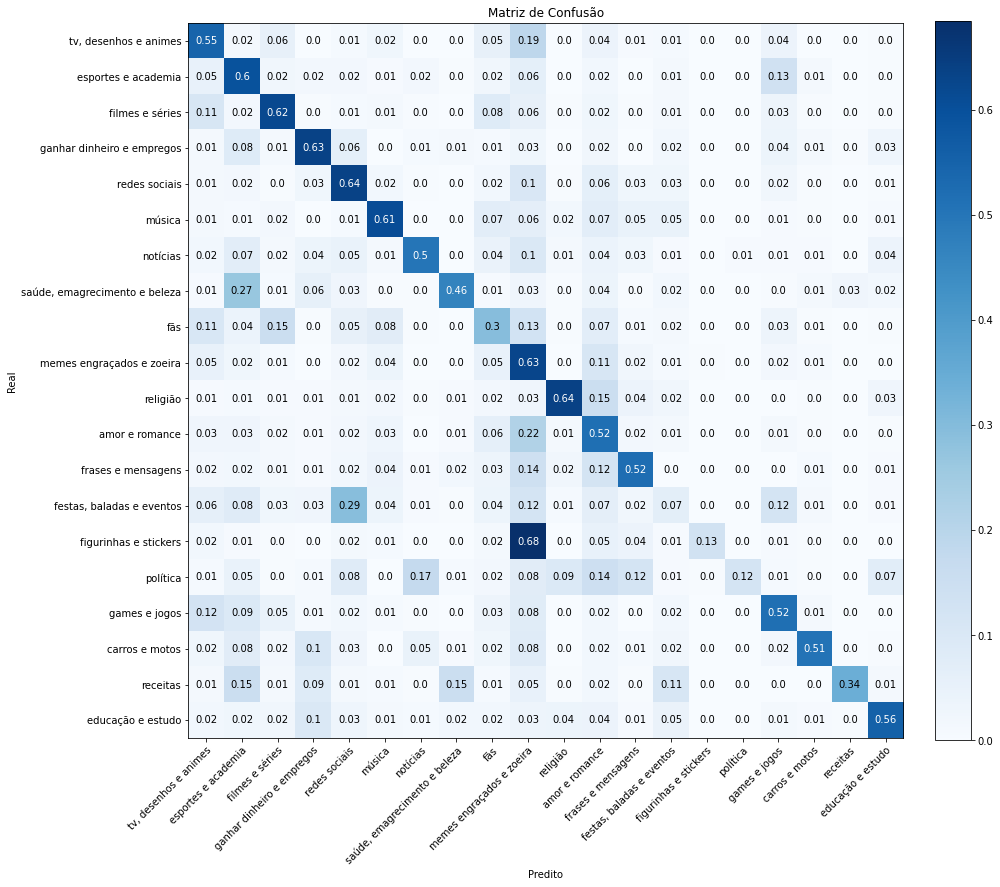

In [ ]:
plot_confusion_matrix(lstm_model_db1, results, CATEGORY_BASE2)

### 7.1.2 - CNN

In [ ]:
results = cnn_model_db1.predict(SENTENCES_BASE2)
y_true = np.argmax(CATEGORY_BASE2, axis=1)
y_pred = np.argmax(results, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53     12526
           1       0.44      0.55      0.49      4052
           2       0.19      0.52      0.28      1932
           3       0.74      0.67      0.71      9043
           4       0.77      0.74      0.75     13482
           5       0.59      0.56      0.57      1959
           6       0.17      0.53      0.26       384
           7       0.74      0.50      0.60      3188
           8       0.34      0.38      0.36      6540
           9       0.31      0.56      0.40      9541
          10       0.64      0.64      0.64      1606
          11       0.28      0.62      0.38      4455
          12       0.15      0.54      0.24       551
          13       0.07      0.02      0.03      2068
          14       0.77      0.10      0.18      5684
          15       0.42      0.04      0.08       490
          16       0.86      0.58      0.69     28795
          17       0.12    

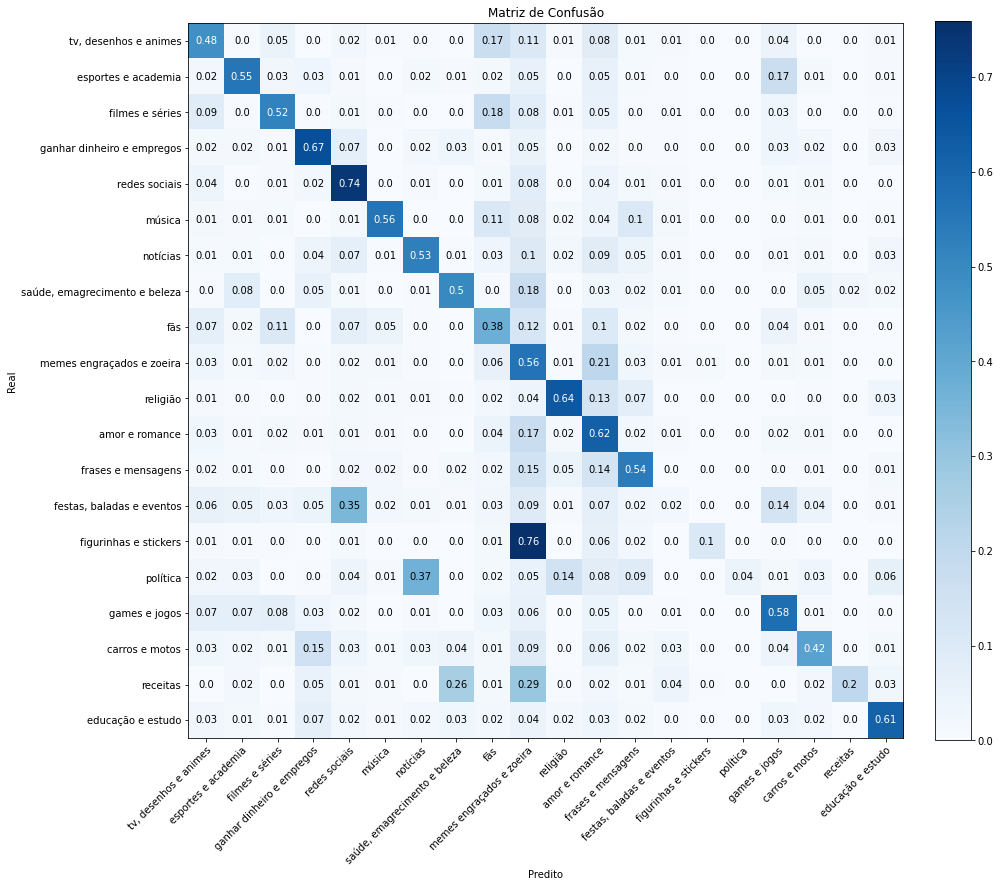

In [ ]:
plot_confusion_matrix(cnn_model_db1, results, CATEGORY_BASE2)

## 7.2 - Avaliando: Modelo Treinado no **Dataset 2** para Predizer o **Dataset 1**


- **Acurácia**: 0.70
- **Macro-F1**: 0.63
- **Weighted**: 0.68

Aqui, vemos um comportamento totalmente oposto. Enquanto o primeiro modelo não consegue um bom resultado no segundo dataset, o oposto ocorre neste teste.

Treinar no segundo dataset e testar no primeiro, temos um bom resultado. Resultado tão bom quanto treinar apenas com o primeiro dataset.

Temos algumas razões para isso:

- O primeiro fato é que o número de dados para treino. Enquanto no dataset 2 temos mais do que 100 mil exemplos, no primeiro dataset temos pouco mais de 17 mil.

- Percebemos que o grande número de exemplos fez com que o segundo modelo tivesse um aprendizado bem superior ao primeiro modelo.

- É possível notar devido ao analisar a matriz de confusão. Este modelo consegue prever muito bem todas as classes.

### 7.1.1 - LSTM

In [ ]:
results = lstm_model_db2.predict(SENTENCES_BASE1)
y_true = np.argmax(CATEGORY_BASE1, axis=1)
y_pred = np.argmax(results, axis=1)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.58      0.67      1786
           1       0.69      0.74      0.71      1060
           2       0.54      0.75      0.63       929
           3       0.82      0.80      0.81      2738
           4       0.78      0.65      0.71       969
           5       0.75      0.80      0.78       953
           6       0.54      0.40      0.46       174
           7       0.70      0.74      0.72       907
           8       0.44      0.57      0.50       896
           9       0.72      0.59      0.65      1053
          10       0.87      0.78      0.83       935
          11       0.58      0.69      0.63       727
          12       0.59      0.60      0.60       371
          13       0.18      0.28      0.22       159
          14       0.63      0.85      0.72       536
          15       0.31      0.76      0.44        83
          16       0.88      0.71      0.79      2394
          17       0.51    

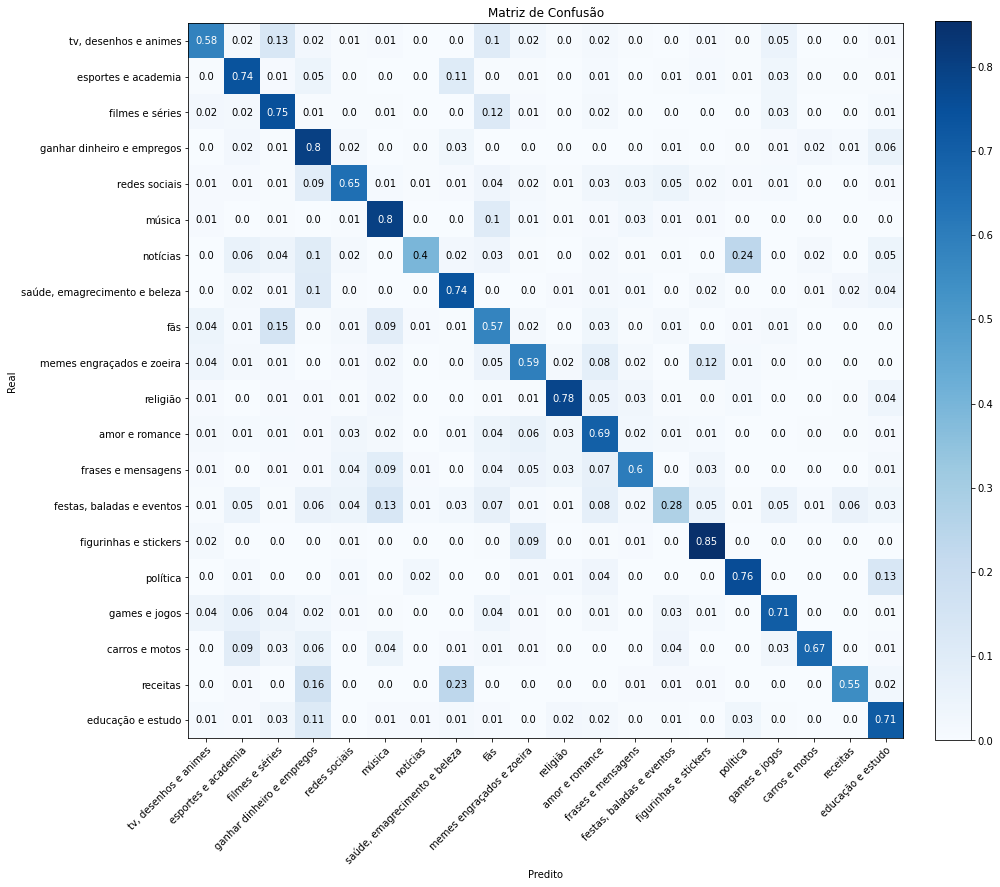

In [ ]:
plot_confusion_matrix(lstm_model_db2, results, CATEGORY_BASE1)

### 7.2.1 - CNN

In [ ]:
results = cnn_model_db2.predict(SENTENCES_BASE1)
y_true = np.argmax(CATEGORY_BASE1, axis=1)
y_pred = np.argmax(results, axis=1)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1786
           1       0.82      0.66      0.73      1060
           2       0.56      0.65      0.60       929
           3       0.78      0.79      0.79      2738
           4       0.73      0.58      0.65       969
           5       0.75      0.76      0.75       953
           6       0.45      0.30      0.36       174
           7       0.64      0.73      0.68       907
           8       0.47      0.51      0.49       896
           9       0.64      0.59      0.61      1053
          10       0.86      0.73      0.79       935
          11       0.55      0.66      0.60       727
          12       0.66      0.51      0.57       371
          13       0.08      0.13      0.10       159
          14       0.60      0.80      0.69       536
          15       0.31      0.52      0.39        83
          16       0.83      0.72      0.77      2394
          17       0.51    

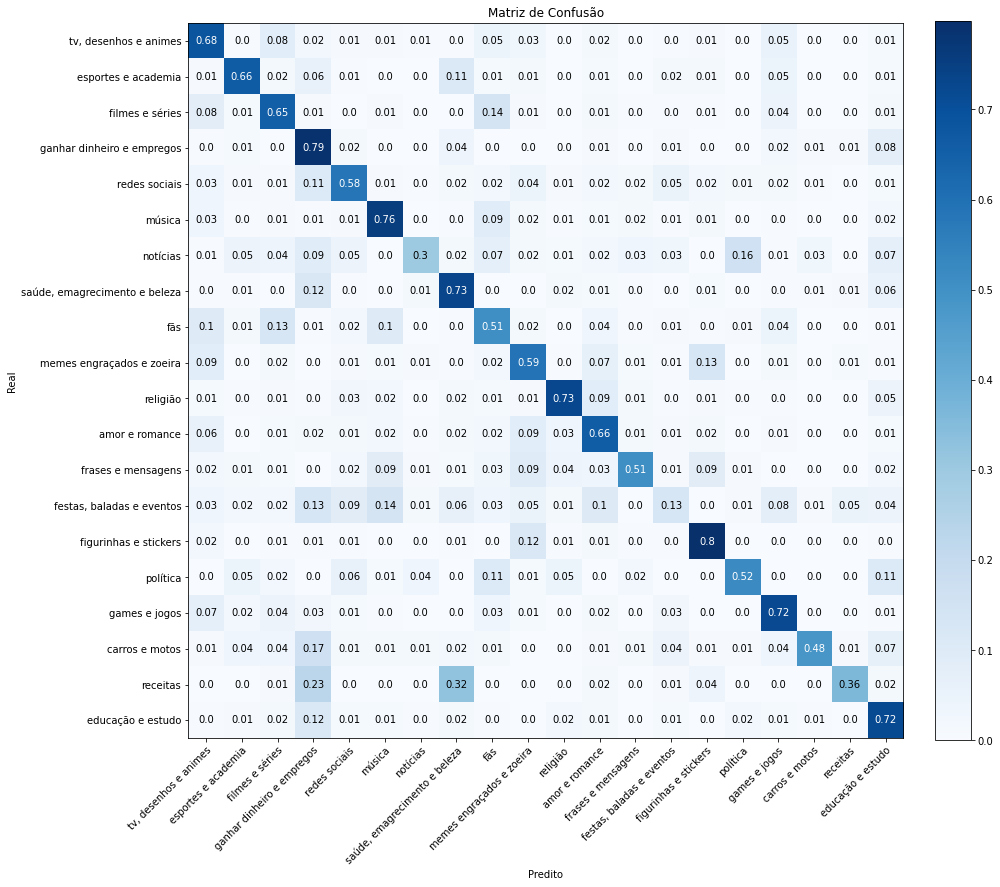

In [ ]:
plot_confusion_matrix(cnn_model_db2, results, CATEGORY_BASE1)

# 8 - CONCLUSÃO

Neste trabalho, analisamos 3 modelos para categorizar grupos públicos do WhatsApp. 

Para isso, analisamos 2 bases de dados com grupos públicos encontrados em 2 sites diferentes. As bases possuem volumes de dados de pouco mais de 17 mil e 119 mil.

Resultados:

- Os modelos LSTM e CNN tiveram os melhores resultados, enquanto o Random Forest não foi muito bem.

- No Dataset 1, alcançamos aproximadamente 70% de Acurácia e 64% de Macro-F1.

- No Dataset 2, conseguimos cerca de 70% de Acurácia de 62% de Macro-F1.

Análises interesantes:

- Apesar das limitações, os modelos conseguem ir razoavelmente bem. Devido ao número de classes, o problema de classificação passa a ser bem complexo. 

- As classes: Fãs, Notícias e Receitas são as mais difíceis de serem categorizadas. Elas são bem próximas a outras classes.

- O volume de dados dos datasets influenciaram bastante no resultado. Quando usamos o modelo treinado em uma base diferente, percebemos que o modelo treinado com mais dados teve um resultado muito superior.

- Além disso, percebemos que o contexto das duas bases são bem similares. Além disso, os resultados em ambas bases são bem parecidos.

